In [1]:
!pip install --upgrade -q tensorflow tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 40.0 MB/s eta 0:00:00


In [2]:
!pip show nest_asyncio kaggle > /dev/null || install --upgrade -q nest_asyncio kaggle

In [3]:
import os
import cv2
import glob
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import multiprocessing
import tensorflow as tf
from pathlib import Path
import concurrent.futures
import keras.backend as K
from time import perf_counter
from functools import lru_cache
import matplotlib.pyplot as plt
from keras import layers, models
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import accuracy_score, classification_report

In [4]:
try:
    tf.config.optimizer.set_jit(True)
    print("Just-In-Time (JIT) compilation has been enabled.")
except Exception as e:
    print("Could not enable Just-In-Time (JIT) compilation: ", e)

try:
    tf.config.threading.set_inter_op_parallelism_threads(4)
    print("Inter operation parallelism threads set to 4.")
except Exception as e:
    print("Could not set Inter operation parallelism threads: ", e)

try:
    tf.config.threading.set_intra_op_parallelism_threads(4)
    print("Intra operation parallelism threads set to 4.")
except Exception as e:
    print("Could not set Intra operation parallelism threads: ", e)

Just-In-Time (JIT) compilation has been enabled.
Inter operation parallelism threads set to 4.
Intra operation parallelism threads set to 4.


In [5]:
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Memory growth has been enabled on the first GPU.")
    except:
        print("Could not set memory growth.")
else:
    print("No GPU detected.")

Memory growth has been enabled on the first GPU.


In [6]:
try:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision training has been enabled.")
except Exception as e:
    print("Could not enable mixed precision training: ", e)

Mixed precision training has been enabled.


In [7]:
import asyncio
import zipfile
import hashlib
import nest_asyncio
import concurrent.futures

nest_asyncio.apply()

DATASETS = [
    ("tawsifurrahman/covid19-radiography-database", "/content/covid19-radiography-database.zip")
]

kaggle_dir = os.path.expanduser("~/.kaggle")
kaggle_json = "kaggle.json"

if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
    os.rename(kaggle_json, os.path.join(kaggle_dir, kaggle_json))
    os.chmod(os.path.join(kaggle_dir, kaggle_json), 0o600)


async def download_dataset(dataset):

    dataset_id, filename = dataset
    if not os.path.exists(filename):
        !kaggle datasets download -d {dataset_id} -p /content


async def extract_dataset(dataset):

    dataset_id, filename = dataset
    if not os.path.exists(dataset_id):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('/content')

async def verify_dataset(dataset):

    dataset_id, filename = dataset
    if not os.path.exists(dataset_id):
        expected_hash = dataset_id.split("/")[1]
        with open(filename, "rb") as file:
            file_hash = hashlib.md5(file.read()).hexdigest()
            if file_hash != expected_hash:
                print(f"Corrupted file: {filename}")
        os.remove(filename)


async def process_dataset(dataset):
 
    await download_dataset(dataset)
    await extract_dataset(dataset)
    await verify_dataset(dataset)


async def main():

    tasks = [process_dataset(dataset) for dataset in DATASETS]
    await asyncio.gather(*tasks)


asyncio.run(main())

 99% 773M/778M [00:24<00:00, 35.4MB/s]
100% 778M/778M [00:24<00:00, 33.8MB/s]
Corrupted file: /content/covid19-radiography-database.zip


In [8]:
dataset = Path(r"/content")
covid_19 = dataset / "COVID-19_Radiography_Dataset"

In [9]:
class_names = [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]
image_paths = []
labels = []

for class_name in class_names:
    class_dir = covid_19 / class_name / 'images'
    if os.path.exists(class_dir):
        file_names = [f_name for f_name in os.listdir(class_dir) if f_name.endswith((".jpeg", ".png"))]

        for f_name in tqdm(file_names, desc=f"Processing {class_name}"):
            image_paths.append(os.path.join(class_dir, f_name))
            labels.append(class_name)

Processing Lung_Opacity: 100%|██████████| 6012/6012 [00:00<00:00, 521318.08it/s]


In [10]:
def is_black_and_white(image):
    return image.mode == 'L' 

Loading and displaying images: 100%|██████████| 4/4 [00:00<00:00, 307.29it/s]


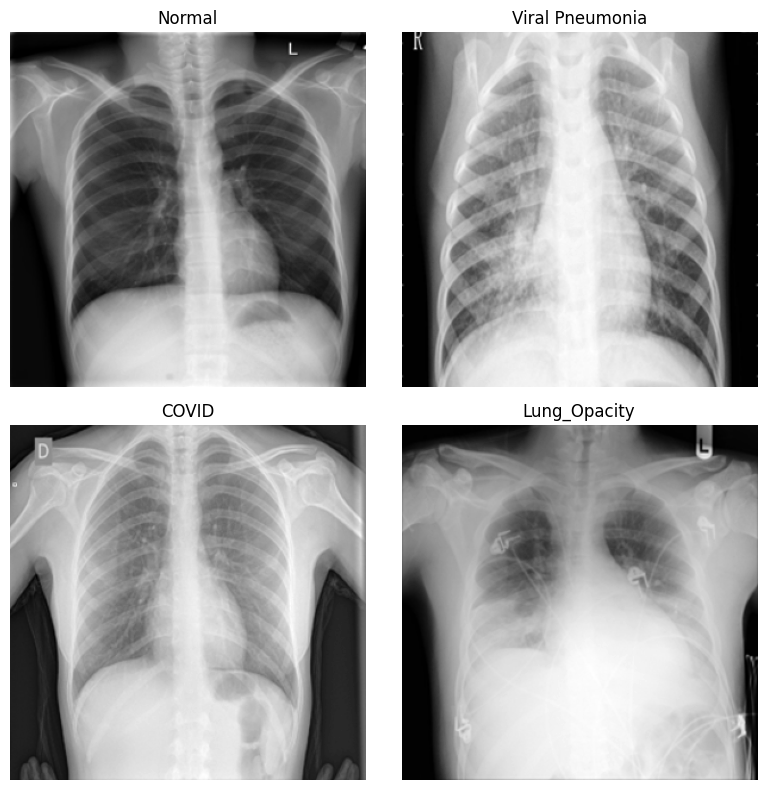

In [13]:
def group_images_by_class(image_paths, labels):
    """
    Group image paths by class label.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        dict: A dictionary where the keys are class labels, and the values are lists of image paths for each class.
    """
    class_to_images = {}
    for img_path, label in zip(image_paths, labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img_path)
    return class_to_images

def display_images_per_class(image_paths, labels):
    class_to_images = group_images_by_class(image_paths, labels)
    num_classes = len(class_to_images)

    num_rows, num_cols = 1, num_classes
    if num_classes == 4:
        num_rows, num_cols = 2, 2
    elif num_classes == 6:
        num_rows, num_cols = 2, 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

    with tqdm(total=num_classes, desc="Loading and displaying images") as pbar:
        for i, (class_label, image_paths_for_class) in enumerate(class_to_images.items()):
            selected_image_path = random.choice(image_paths_for_class)
            try:
                selected_image = Image.open(selected_image_path)
                if is_black_and_white(selected_image):
                    ax = axs[i // num_cols, i % num_cols]
                    ax.imshow(selected_image, cmap='gray')
                    ax.set_title(class_label)
                    ax.axis('off')
            except Exception as e:
                print(f"Error loading image: {selected_image_path}")
                print(e)

            pbar.update(1) 

    plt.tight_layout()
    plt.show()

display_images_per_class(image_paths, labels)

In [15]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

In [16]:
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths,
                                                                      labels_encoded,
                                                                      test_size=0.1,
                                                                      random_state=42,
                                                                      stratify=labels_encoded)

train_paths, test_paths, train_labels, test_labels= train_test_split(train_paths,
                                                                    train_labels,
                                                                    test_size=0.2222,
                                                                    random_state=42,
                                                                    stratify=train_labels)

In [17]:
train_df = pd.DataFrame({'File Paths': train_paths, 'Labels': train_labels})
val_df = pd.DataFrame({'File Paths': val_paths, 'Labels': val_labels})
test_df = pd.DataFrame({'File Paths': test_paths, 'Labels': test_labels})

total_train_samples = len(train_df)
total_val_samples = len(val_df)
total_test_samples = len(test_df)

train_percentage = (total_train_samples / len(labels_encoded)) * 100
val_percentage = (total_val_samples / len(labels_encoded)) * 100
test_percentage = (total_test_samples / len(labels_encoded)) * 100

train_counts = train_df['Labels'].value_counts().sort_index()
val_counts = val_df['Labels'].value_counts().sort_index()
test_counts = test_df['Labels'].value_counts().sort_index()

train_df = pd.DataFrame({'Train Samples': train_counts})
val_df = pd.DataFrame({'Validation Samples': val_counts})
test_df = pd.DataFrame({'Test Samples': test_counts})

train_df.index = val_df.index = test_df.index = class_names

print("Total Train Samples:", total_train_samples)
print("Total Validation Samples:", total_val_samples)
print("Total Test Samples:", total_test_samples)
print("\nPercentage of Split:")
print("Train: {:.2f}%".format(train_percentage))
print("Validation: {:.2f}%".format(val_percentage))
print("Test: {:.2f}%".format(test_percentage))
print("\nClass Distribution:")
result_df = pd.concat([train_df, val_df, test_df], axis=1)
print(result_df)

Total Train Samples: 14815
Total Validation Samples: 2117
Total Test Samples: 4233

Percentage of Split:
Train: 70.00%
Validation: 10.00%
Test: 20.00%

Class Distribution:
                 Train Samples  Validation Samples  Test Samples
Normal                    2531                 362           723
Viral Pneumonia           4209                 601          1202
COVID                     7134                1019          2039
Lung_Opacity               941                 135           269


In [18]:
def image_generator(img_paths, img_labels, batch_size):
    """Generator function to load and preprocess images in batches.

    Args:
        img_paths (list): List of image file paths.
        img_labels (list): List of corresponding image labels.
        batch_size (int): Size of the batch.

    Yields:
        tuple: A tuple containing the batch of images and their corresponding labels.
    """
    num_samples = len(img_paths)

    while True:
        for offset in range(0, num_samples, batch_size):
            batch_paths = img_paths[offset:offset + batch_size]
            batch_labels = img_labels[offset:offset + batch_size]

            batch_images = []
            for img_path in batch_paths:
                image = cv2.imread(str(img_path))
                resized_image = cv2.resize(image, (224, 224))
                normalized_image = resized_image / 255.0
                batch_images.append(normalized_image)

            yield np.array(batch_images), to_categorical(batch_labels, num_classes)

In [19]:
BATCH_SIZE = 16

train_generator = image_generator(train_paths, train_labels, BATCH_SIZE)
train_steps = len(train_paths) // BATCH_SIZE

val_generator = image_generator(val_paths, val_labels, BATCH_SIZE)
val_steps = len(val_paths) // BATCH_SIZE

test_generator = image_generator(test_paths, test_labels, BATCH_SIZE)
test_steps = len(test_paths) // BATCH_SIZE

In [20]:
class TwiceMaxMinPooling2D(layers.Layer):
    """
    Custom layer that performs twice max-min pooling on a 2D input tensor.
    """

    def __init__(self, pool_size=(2, 2), strides=2, factor=1.0, padding="SAME", **kwargs):
        """
        Initialize the TwiceMaxMinPooling2D layer.

        Args:
            pool_size (tuple): Size of the pooling window (default: (2, 2)).
            strides (int): Stride size for the pooling window (default: 2).
            factor (float): Scaling factor (not used in current implementation) (default: 1.0).
            padding (str): Padding mode for the input tensor (default: "SAME").
            **kwargs: Additional keyword arguments passed to the base class constructor.
        """
        super(TwiceMaxMinPooling2D, self).__init__(**kwargs)

        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
        self.factor = tf.constant(factor, dtype=tf.float32)

    def get_config(self):
        """
        Get the configuration of the TwiceMaxMinPooling2D layer.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            "pool_size": self.pool_size,
            "strides": self.strides,
            "padding": self.padding
        })
        return config

    @tf.function
    def call(self, inputs, *args, **kwargs):
        """
        Perform the computation for the TwiceMaxMinPooling2D layer.

        Args:
            inputs (tf.Tensor): Input tensor.
            *args: Additional positional arguments.
            **kwargs: Additional keyword arguments.

        Returns:
            tf.Tensor: Output tensor.
        """
        batch, height, width, channel = inputs.shape

        patch = tf.image.extract_patches(
            inputs,
            sizes=[1, self.pool_size[0], self.pool_size[1], 1],
            strides=[1, self.strides, self.strides, 1],
            rates=[1, 1, 1, 1],
            padding=self.padding
        )

        out_shape = tf.shape(patch)
        out_batch = out_shape[0]
        out_height = out_shape[1]
        out_width = out_shape[2]
        out_channel = out_shape[3]

        patch = tf.reshape(
            patch, (out_batch, out_height, out_width, self.pool_size[0] * self.pool_size[1], channel)
        )

        max_values = tf.math.reduce_max(patch, axis=3)
        min_values = tf.math.reduce_min(patch, axis=3)
        pooled_output = 2 * max_values - min_values

        output = tf.cast(pooled_output, tf.float32)

        return output

In [21]:
def process_image(image_path, p_s, s, p):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, axis=0)

    twicemaxminpool_layer = TwiceMaxMinPooling2D(pool_size=p_s, strides=s, padding=p)

    twicemaxmin_image = twicemaxminpool_layer(image_tensor)

    twicemaxmin_image = np.squeeze(twicemaxmin_image.numpy(), axis=0)

    return image, twicemaxmin_image

def visualize_results(cls_n, *img_t_ps):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i, (img_t, ax) in enumerate(zip(img_t_ps, axes)):
        img, title = img_t
        if not isinstance(img, np.ndarray):
            raise TypeError(f"Image {i+1} is not a valid numpy array.")
        if len(img.shape) != 3 or img.shape[2] != 3:
            raise ValueError(f"Image {i+1} is not a valid BGR image.")

        ax.imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

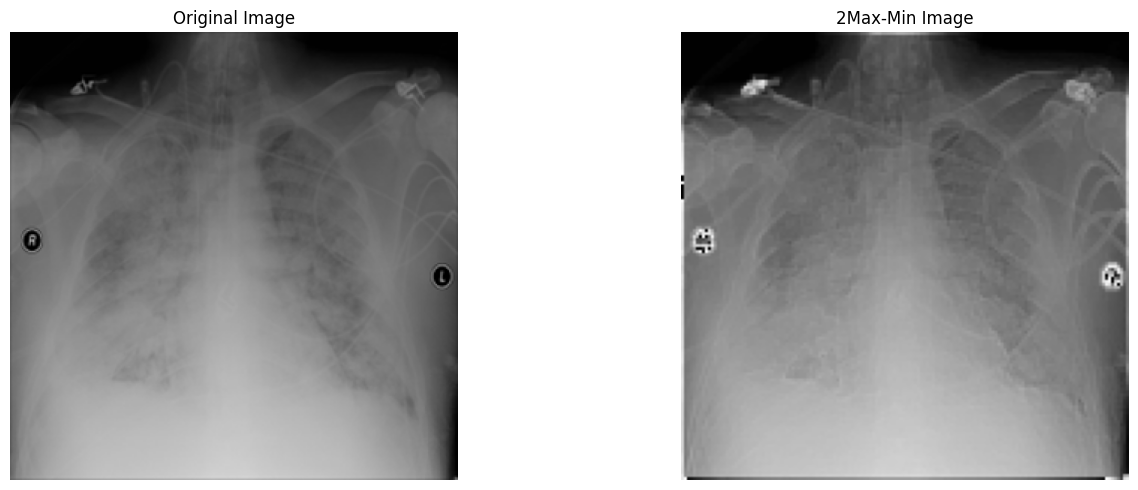

In [22]:
random_index = random.randint(0, len(image_paths) - 1)
random_image_path = image_paths[random_index]
random_label = labels[random_index]

po_si = (3, 3)
st = 2
pa = "SAME"

original_image, twicemaxmin_image = process_image(random_image_path, po_si, st, pa)

image_title_pairs = [(original_image, "Original Image"),
                     (twicemaxmin_image, "2Max-Min Image")]

visualize_results(random_label, *image_title_pairs)

In [23]:
inputs = layers.Input(shape=(224, 224, 3), name="Input")

x = layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", name="Conv1")(inputs)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv1")(x)
x = layers.BatchNormalization()(x)
blk1 = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool1")(x)

x = layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu", name="Conv2")(blk1)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv2")(x)
x = layers.BatchNormalization()(x)
blk2 = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool2")(x)

x = layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", name="Conv3")(blk2)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same", name="MaxPool3")(x)
x = layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", name="Conv4")(x)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv3")(x)
x = layers.BatchNormalization()(x)
blk3 = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool4")(x)

x = layers.Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu", name="Conv5")(blk3)
x = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool5")(x)
x = layers.Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu", name="Conv6")(x)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv4")(x)
blk4 = layers.BatchNormalization()(x)

y = TwiceMaxMinPooling2D(pool_size=(3, 3))(blk2)
y = layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", name="Conv7")(y)
y = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool7")(y)
y = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv5")(y)
y = layers.Conv2D(64, kernel_size=(5, 5), padding="same", activation="relu", name="Conv8")(y)
y = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool8")(y)
y = layers.Conv2D(224, kernel_size=(3, 3), padding="same", activation="relu", name="Conv9")(y)
blk5 = layers.BatchNormalization()(y)


x = layers.Concatenate(name="DirectConcat")([blk4, blk5])

x = layers.GlobalAveragePooling2D(name="GAP")(x)

outputs = layers.Dense(num_classes, activation="softmax", name="Output")(x)

model = models.Model(inputs=inputs, outputs=outputs)

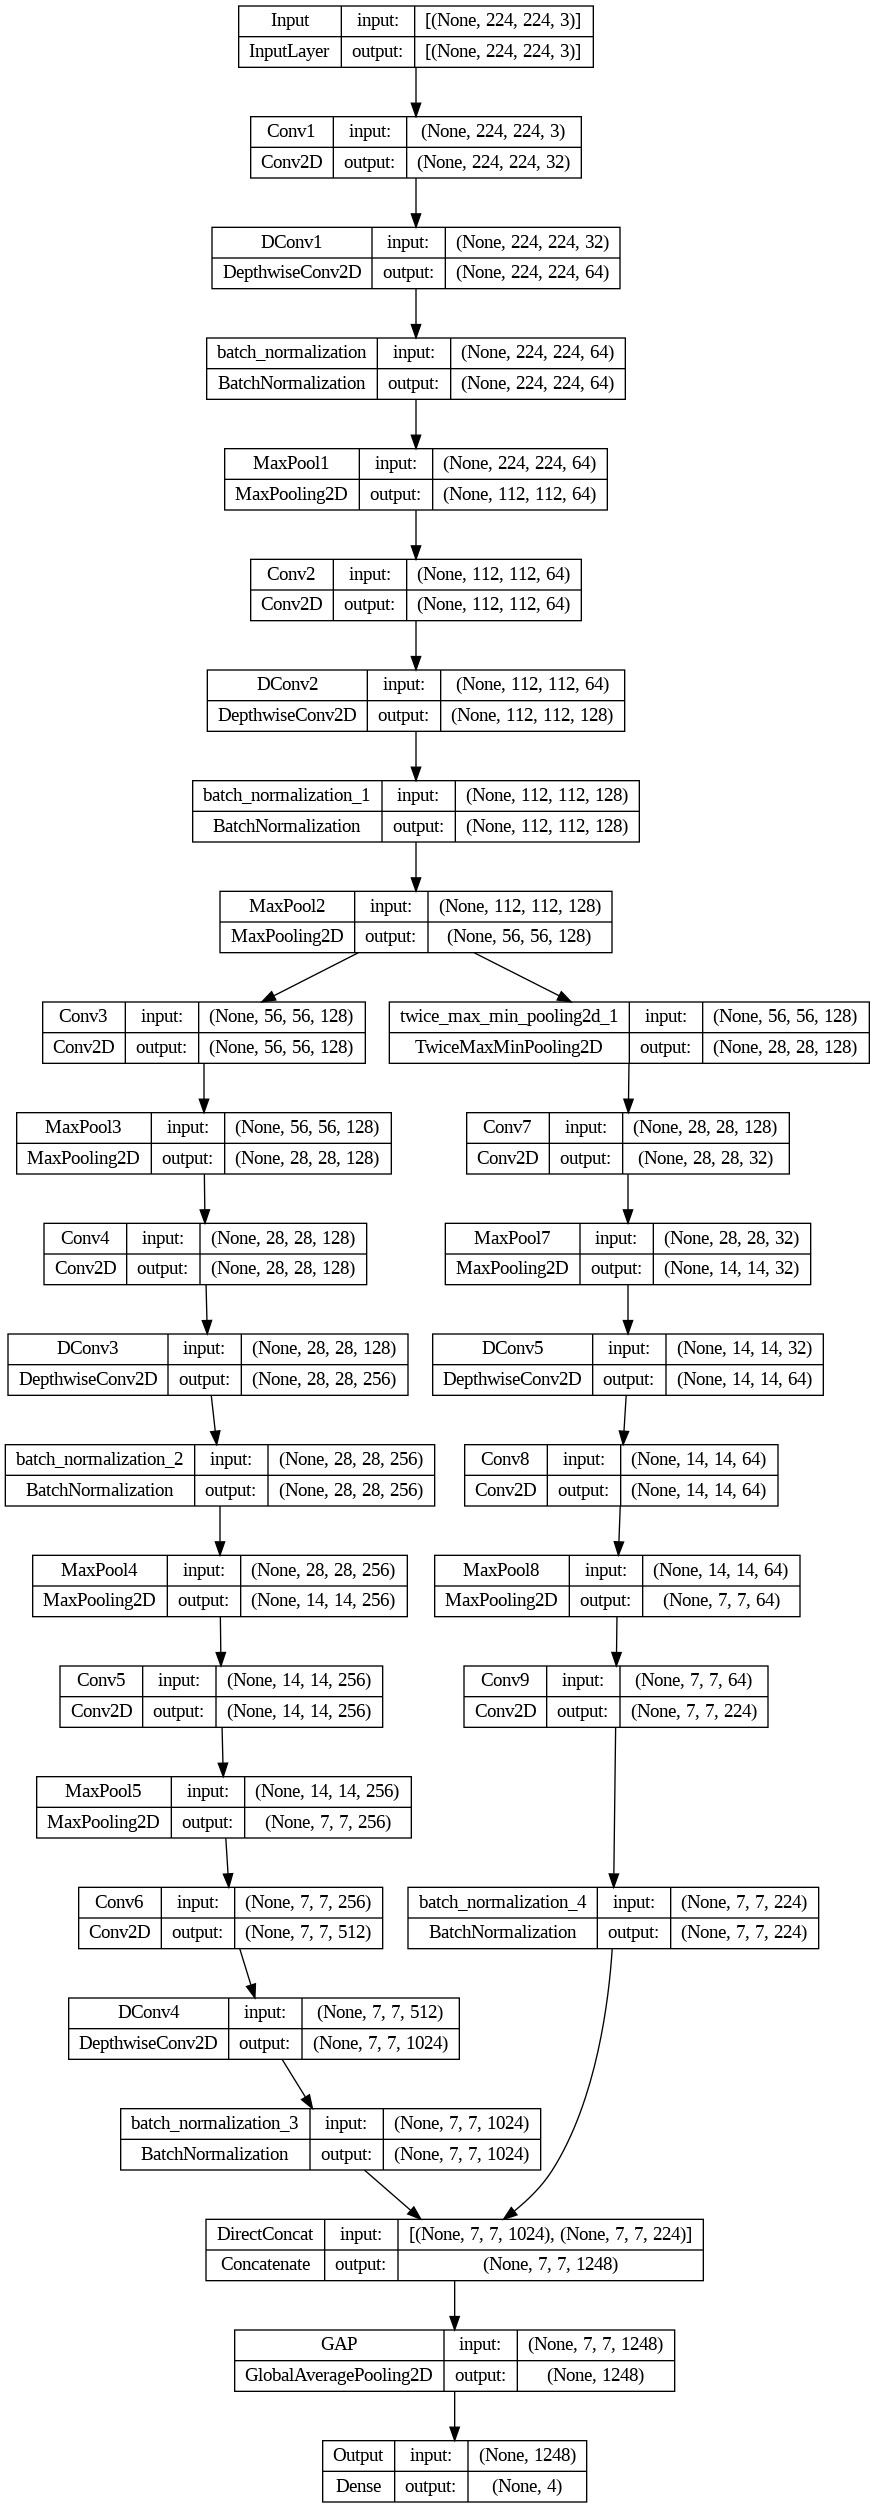

In [24]:
plot_model(model, show_shapes=True)

In [25]:
def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, sensitivity, specificity, mcc, auc).
    """

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return (
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric
    )

In [26]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', create_metrics()]
)

In [27]:
TOTAL_EPOCHS = 25
INITIAL_LEARNING_RATE = 0.75e-4
DECAY_RATE = 0.96

def learning_rate_scheduler(epoch, current_learning_rate):
    if epoch < (TOTAL_EPOCHS / 3):
        new_learning_rate = INITIAL_LEARNING_RATE
    else:
        new_learning_rate = current_learning_rate * DECAY_RATE

    return new_learning_rate

In [28]:
learning_rate_callback = LearningRateScheduler(learning_rate_scheduler)

In [29]:
start_time = perf_counter()
history = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    steps_per_epoch=train_steps,
    callbacks=[learning_rate_callback],
    validation_data=val_generator,
    validation_steps=val_steps
)
end_time = perf_counter()

Epoch 1/25
925/925 [==============================] - 135s 118ms/step - loss: 0.5673 - accuracy: 0.8017 - precision: 0.8590 - recall: 0.7277 - f1_score: 0.7758 - specificity: 0.9602 - sensitivity: 0.7277 - mcc: 0.7237 - auc: 0.9465 - val_loss: 0.9480 - val_accuracy: 0.6155 - val_precision: 0.6508 - val_recall: 0.5833 - val_f1_score: 0.6141 - val_specificity: 0.8957 - val_sensitivity: 0.5833 - val_mcc: 0.4975 - val_auc: 0.8720 - lr: 7.5000e-05
Epoch 2/25
925/925 [==============================] - 109s 115ms/step - loss: 0.2917 - accuracy: 0.8963 - precision: 0.9083 - recall: 0.8839 - f1_score: 0.8954 - specificity: 0.9702 - sensitivity: 0.8839 - mcc: 0.8619 - auc: 0.9840 - val_loss: 0.9134 - val_accuracy: 0.6559 - val_precision: 0.6642 - val_recall: 0.6373 - val_f1_score: 0.6508 - val_specificity: 0.8928 - val_sensitivity: 0.6382 - val_mcc: 0.5384 - val_auc: 0.8998 - lr: 7.5000e-05
Epoch 3/25
925/925 [==============================] - 137s 148ms/step - loss: 0.2151 - accuracy: 0.9254 - 

In [30]:
execution_time = end_time - start_time

milliseconds = int(execution_time * 1000)
seconds, milliseconds = divmod(milliseconds, 1000)
minutes, seconds = divmod(seconds, 60)
hours, minutes = divmod(minutes, 60)

time_string = f"{hours} hours, " if hours else ""
time_string += f"{minutes} minutes, " if minutes else ""
time_string += f"{seconds} seconds, " if seconds else ""
time_string += f"{milliseconds} milliseconds"

print(f"Model training took {time_string}")

Model training took 46 minutes, 17 seconds, 734 milliseconds


In [31]:
_ = model.evaluate(test_generator, steps=test_steps)

264/264 [==============================] - 16s 59ms/step - loss: 0.4681 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9351 - f1_score: 0.9352 - specificity: 0.9785 - sensitivity: 0.9351 - mcc: 0.9137 - auc: 0.9765


In [32]:
def plot_metrics(hist, metric_name_list):
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.set_xlabel("Epochs")
        ax.legend()

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

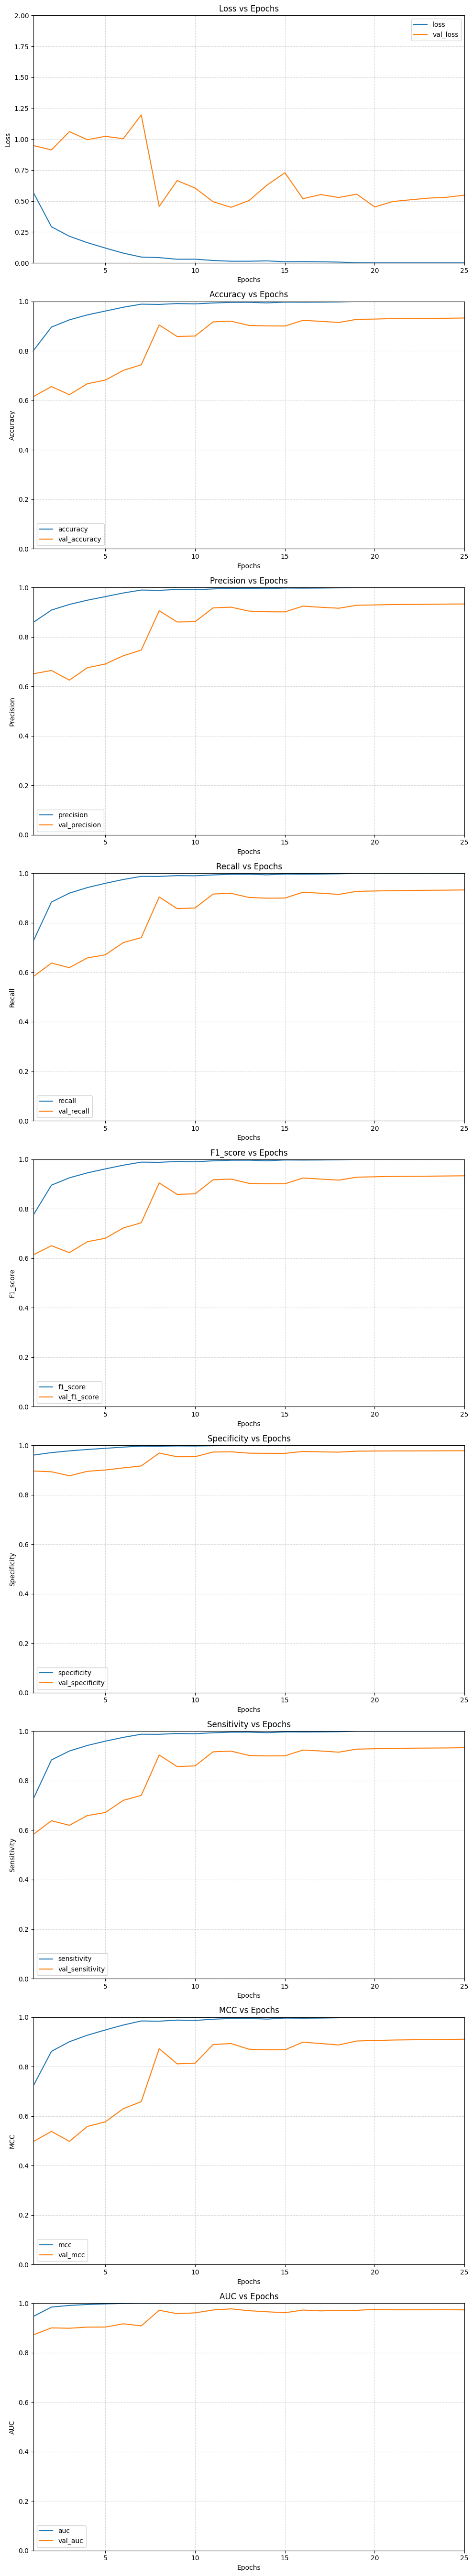

In [33]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
plot_metrics(history, metric_names)

In [34]:
def generate_classification_report(model, test_generator, test_steps, batch_size, target_names):
    predicted_labels = []
    true_labels = []

    for i in range(test_steps):
        batch_data, batch_true_labels = next(test_generator)

        batch_predicted_labels = model.predict_on_batch(batch_data)
        batch_predicted_labels = np.argmax(batch_predicted_labels, axis=1)

        predicted_labels.extend(batch_predicted_labels)
        true_labels.extend(batch_true_labels)

    true_labels = np.array(true_labels)

    if len(true_labels[0]) > 1:
        true_labels = np.argmax(true_labels, axis=1)

    report = classification_report(
        true_labels,
        predicted_labels,
        target_names=target_names,
        digits=4,
        zero_division=1
    )

    accuracy = accuracy_score(true_labels, predicted_labels)
    num_errors = np.sum(true_labels != predicted_labels)

    print(report)
    print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

    return true_labels, predicted_labels

In [35]:
true_labels, predicted_labels = generate_classification_report(
    model, test_generator, test_steps, BATCH_SIZE, classes
)

                 precision    recall  f1-score   support

          COVID     0.9842    0.9526    0.9682       718
   Lung_Opacity     0.9204    0.8781    0.8988      1198
         Normal     0.9206    0.9577    0.9388      2033
Viral Pneumonia     0.9848    0.9701    0.9774       268

       accuracy                         0.9350      4217
      macro avg     0.9525    0.9397    0.9458      4217
   weighted avg     0.9354    0.9350    0.9349      4217

There were 274 errors in 4217 tests for an accuracy of  93.50


In [36]:
def confusion_matrix(true_labels, predicted_labels, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    np.add.at(cm, (true_labels, predicted_labels), 1)
    return cm

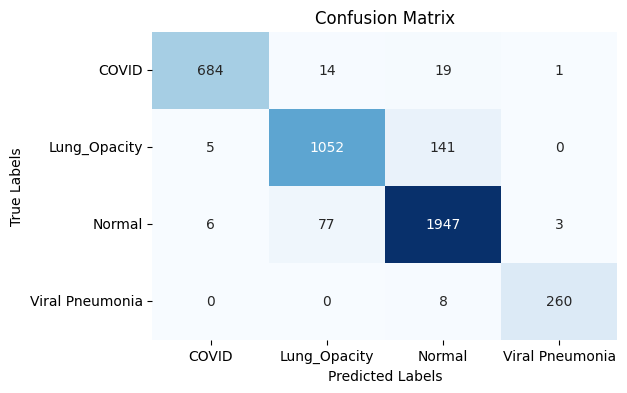

In [37]:
cm = confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()